# Fit FELTOR magnetic field coefficients to experimental equilibrium

This notebook explains how to convert an experimental magnetic field equilibrium to an input file for FELTOR. 
It is recommended to read up on how FELTOR sets up the magnetic field in the documentation "feltor/src/feltor/feltor.tex" (compile to pdf using make doc).

## 1. Reading and exploring experimental data

First, we need to read and understand the experimental magnetic field data. What we are looking for is the poloidal flux function $\psi_p(R,Z)$ and the toroidal magnetic field $B_\varphi(R,Z)$. Unfortunately the format of this kind of data is not standardised and it is also not standardised in what coordinate system ($(R,Z,\varphi)$ vs $(R,\varphi,Z)$) or normalisation $\psi_p$ or $B_\varphi$ are given.
(You can read more on this principle problem in this paper on Coordinate Conventions(COCOS)  https://crppwww.epfl.ch/~sauter/cocos/Sauter_COCOS_Tokamak_Coordinate_Conventions.pdf from this website https://crppwww.epfl.ch/~sauter/cocos/)

What this means in practise is that you need to ask the person who provides the data either the COCOS convention (if they know and the file consistently follows it; in experience people rarely know) OR **you need to ask**:

- What is the direction of the toroidal angle $\varphi$, clockwise or anti-clockwise if viewed from above?
- Is $\psi_p$ is defined with a factor $2\pi$ (i.e. is $e=1$ or $e=0$ below)?
- Is $\psi_p$ defined with a sign (you are looking for $\sigma$ below)?

In short you need to be able to completely confirm the sign convention in
\begin{align}
\vec B_t &= \frac{F}{R}\hat e_\varphi \\
\vec B_p &= \frac{\sigma}{(2\pi)^e} \nabla \varphi \times\nabla \psi_p
\end{align}
where $\sigma = \pm 1$  and $e=\{0,1\}$.

The **file format** we are looking for is anything that can be read in python, preferably *netcdf*, the *geqdsk* file format or *matlab*. This notebook assumes a matlab file and lists alternatives in comments which you may want to use.

In [1]:
import numpy as np
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from pyfeltor import dg # https://github.com/feltor-dev/pyfeltor (We need the geometry backend installed!)

### Case 1: Matlab file (remove below cells if it does not apply)
Here, we assume that we have given a matlab file containing an experimental profile from TCV that we want to fit using FELTOR's polynomial fit. 

In [2]:
import scipy.io
# First we load the matlab file
file = "eq_TCV"

mat = scipy.io.loadmat(file + ".mat")

# and display its content
scipy.io.whosmat(file + ".mat")

[('eq', (1, 1), 'struct')]

In [3]:
# The 'eq' struct is a structured ndarray and contains several variables
mat["eq"].dtype.names

('Bpol', 'Bphi', 'R', 'Z', 'psi', 'BR', 'BZ', 'R_wall', 'Z_wall')

In [4]:
# Let us load the data
print("Loading data ... ")
# The first two 0s are because of how the data is stored
R = mat["eq"]["R"][0][0][:, :]
Z = mat["eq"]["Z"][0][0][:, :]
Psi = mat["eq"]["psi"][0][0][:, :]
BR = mat["eq"]["BR"][0][0][:, :]
BZ = mat["eq"]["BZ"][0][0][:, :]
Bpol = mat["eq"]["Bpol"][0][0][:, :]
Bphi = mat["eq"]["Bphi"][0][0][:, :]
R_wall = mat["eq"]["R_wall"][0][0]  # not used for now
Z_wall = mat["eq"]["Z_wall"][0][0]  # not used for now
print(R.shape)

Loading data ... 
(1520, 540)


### Case 2: eqdsk file (Remove below cells if it does not apply)
The documentation to the freeqdsk package https://freeqdsk.readthedocs.io/en/stable/geqdsk.html is very well-written and strongly recommended to understand the eqdsk file formats. 

In [5]:
# from freeqdsk import geqdsk
# file = "MAST_48004_450ms"
# with open(file+".geqdsk", "r") as f:
#     data = geqdsk.read(f)

In [6]:
# # First, we need to find out some consistency tests
# # From the documentaton data['simagx'] is the flux on the axis
# print( "On axis flux ", data['psi'].min(), data['simagx'])
# print( "boundary flux ", data['psi'].max(), data['sibdry'])

In [7]:
# # Let us load the data 

# print( "Loading data ... ")
# R_ = np.linspace( data["rleft"], data["rleft"]+data["rdim"], data['nx'])
# Z_ = np.linspace( data["zmid"]-data['zdim']/2, data["zmid"]+data['zdim']/2,data['ny'])

# (R,Z) = np.meshgrid( R_,Z_)
# Psi = np.transpose(data['psi'][:,:]) # Psi in here has a negative sign for some reason
# # B_t = F(Psi(R,Z))/R
# psi_exp = np.linspace(data["simagx"], data["sibdry"], data["nx"])
# Bphi = np.interp( Psi, psi_exp, data['fpol'][:])/R

# Psi = -Psi
# print(Bphi.shape)

From the developpers of freeqdsk also comes a cocos tester:

In [8]:
# from pyloidal import cocos
# import itertools
# # Cocos consistency tests

# clockwise_phi = False # not in the file, you need to know somehow
# print( f"Plasma current {data['cpasma']} b_toroidal {data['bcentr']}\
#  safety_factor {data['qpsi'][0]} poloidal flux {data['simagx']} {data['sibdry']}")

# chain = cocos.identify_cocos( data['bcentr'], data['cpasma'], -data['qpsi'], 
#                     np.linspace(data["simagx"], data["sibdry"], data["nx"]),
#                     False)
# print(chain)

In [9]:
# # If we know the coordinate conventions we can numerically derive
# dPsidZ = np.diff( Psi, axis=0)/np.diff( Z, axis=0)
# dPsidR = np.diff( Psi, axis=1)/np.diff( R, axis=1)
# dPsidZ=np.append(np.zeros((1,(np.shape(Psi)[1]))),dPsidZ, axis=0)
# dPsidR=np.append(np.zeros(((np.shape(Psi)[0]),1)),dPsidR, axis=1)
# #print( np.shape(dPsidz))
# BR =-1/R*dPsidZ
# BZ = 1/R*dPsidR
# Bpol = np.sqrt( BR**2+BZ**2)

### First plot
Now let us plot the flux function and the B - field that we just read

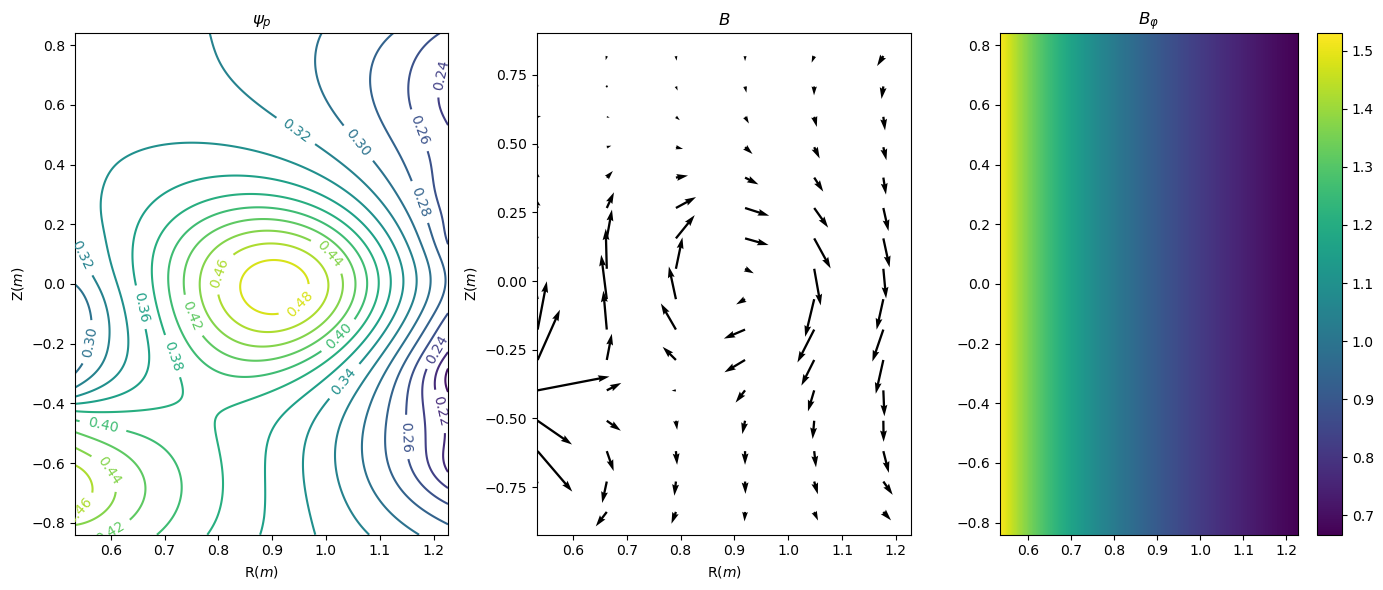

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(14, 6), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R, Z, Psi, 15)
ax.clabel(cf)
ax.set_xlabel(r"R($m$)")
ax.set_ylabel(r"Z($m$)")
ax.set_title(r"$\psi_p$")
ax = axes[0][1]
q = ax.quiver(
    R[::100, ::100], Z[::100, ::100], BR[::100, ::100], BZ[::100, ::100], units="width"
)
ax.set_xlabel(r"R($m$)")
ax.set_ylabel(r"Z($m$)")
ax.set_title(r"$B$")
ax = axes[0][2]
cf = ax.pcolormesh(R, Z, Bphi)
fig.colorbar(cf, ax=ax)
ax.set_title(r"$B_\varphi$")
fig.tight_layout()

plt.show()

In [11]:
# Let us also print the location of the O-point
o_point = np.where(Psi == np.min(Psi))
if abs(Bpol[o_point] / Bphi[o_point]) > 0.1:
    o_point = np.where(Psi == np.max(Psi))
    
if abs(Bpol[o_point] / Bphi[o_point]) > 0.1:
    print("O-point not found!", Bpol[o_point], Bphi[o_point])
else  :   
    print("O-point at (R_O,Z_O) = ", R[o_point], Z[o_point])

# eqdsk files have the magnetic axis written in them :
# print( "Magnetic axis from file: ", data['rmagx'], data['zmagx'])

O-point at (R_O,Z_O) =  [0.90557141] [-0.00940092]


## Orientation and consistency (this may be different for your case)

From an external documentation of the "eq_TCV.mat" file we know that the data bases on Cylindrical right handed coordinate system $R,\varphi,Z$ (i.e. $\hat e_\varphi$ is **anti-clock wise** if viewed from the top) 
and the magnetic field is given by
\begin{align}
\vec B = \frac{1}{R}\left( I \hat e_\varphi + \vec \nabla \psi \times \hat e_\varphi \right) = \frac{1}{R}\left( I \hat e_\varphi - \frac{\partial \psi}{\partial Z} \hat e_R + \frac{\partial \psi}{\partial R} \hat e_Z \right)
\end{align}


From the above plot we realize that with $B_\varphi >0$ **the toroidal field is anti-clockwise** if viewed from the top, with gradB of ions upwards, un-favourable for H-mode. Together with the poloidal field we have a **right handed winding**.

Further, we need to determine if the flux function contains a factor $2\pi$, which some equilibrium codes include. We thus test if the contained magnetic field is consistent with the flux function and fulfills
\begin{align}
B_R = -\frac{1}{R} \frac{\partial \psi}{\partial Z} \\
B_Z = +\frac{1}{R} \frac{\partial \psi}{\partial R} 
\end{align}

In [12]:
# This consistency test can only be done if your file contains BR and BZ!! (Remove if not applicable)
# Numerically derive
dPsidZ = np.diff(Psi, axis=0) / np.diff(Z, axis=0)
dPsidR = np.diff(Psi, axis=1) / np.diff(R, axis=1)
dPsidZ = np.append(np.zeros((1, (np.shape(Psi)[1]))), dPsidZ, axis=0)
dPsidR = np.append(np.zeros(((np.shape(Psi)[0]), 1)), dPsidR, axis=1)
# print( np.shape(dPsidz))
BR_num = -1 / R * dPsidZ
BZ_num = 1 / R * dPsidR

# print the first element
print(abs(BR[1, 0] - BR_num[1, 0]) / BR[1, 0])
print(abs(BZ[1, 1] - BZ_num[1, 1]) / BZ[1, 1])

-5.246362097555394
-5.083237805536858


We see that the numerical derivative is different from the stored magnetic field. There is a factor $2\pi$ in Psi that we need to divide.

In [13]:
Psi = Psi / 2 / np.pi

In [14]:
# Numerically derive
dPsidZ = np.diff(Psi, axis=0) / np.diff(Z, axis=0)
dPsidR = np.diff(Psi, axis=1) / np.diff(R, axis=1)
dPsidZ = np.append(np.zeros((1, (np.shape(Psi)[1]))), dPsidZ, axis=0)
dPsidR = np.append(np.zeros(((np.shape(Psi)[0]), 1)), dPsidR, axis=1)
# print( np.shape(dPsidz))
BR_num = -1 / R * dPsidZ
BZ_num = 1 / R * dPsidR

# print the first element
print(abs(BR[1, 0] - BR_num[1, 0]) / BR[1, 0])
print(abs(BZ[1, 1] - BZ_num[1, 1]) / BZ[1, 1])

-0.005860595832182501
-0.031822633245204346


We consider the remaining difference negligible.

## 2 FELTOR Normalization and Transformtion

FELTOR's coordinate system is a 
right-handed $(R,Z,\varphi')$ (instead of $(R,\varphi,Z)$, which means that FELTOR's $\hat e_\varphi' = - \hat e_\varphi$ points **clockwise** if viewed from the top and we have
  \begin{align}
\vec B = \frac{1}{R}\left( I \hat e_\varphi' + \vec \nabla \psi \times \hat e_\varphi' \right) = \frac{1}{R}\left( I \hat e_\varphi' + \frac{\partial \psi}{\partial Z} \hat e_R - \frac{\partial \psi}{\partial R} \hat e_Z \right)
\end{align} 

We thus need to make the identification (**may be different for your case!**)
\begin{align}
\psi \rightarrow -\psi \\
I \rightarrow -I \\
B_\varphi \rightarrow - B_\varphi
\end{align}





### A note on normalisation and scaling
FELTOR normalizes the magnetic data to
\begin{align}
\bar R &= \frac{R}{\rho_s} \quad \bar  Z = \frac{Z}{\rho_s} \\
\bar \psi &= \frac{\psi}{B_0R_0 \rho_s} \\
\bar B &= \frac{B}{B_0} \\
\bar I &= \frac{I}{R_0B_0}
\end{align}
Here, $R_0$ is the refrence major radius, $B_0$ is a reference magnetic field and $\rho_s$ is a reference normalisation length-scale.

Consider: if $I(\psi)$, $\psi(R,Z)$ is a solution to the Grad-Shafranov equation then so is $\alpha I(\psi)$, $\alpha \psi( \beta R, \beta Z)$ (with appropriately scaled pressure profile). There are thus two degrees of freedom. What this graphically means is that a magnetic field can be arbitrarily scaled in size and strength. The only thing that is fixed is the **shape** of the field (things like the safety factor stay invariant). The philosophy of writing magnetic field representations (or files) in FELTOR is that only a reference field can be stored which when used can be arbitrarily scaled to fit the simulation purpose. 

- **fix the reference normalisation scale $\rho_s = 1$m** (Yes, one meter, don't think about it too hard!)
- **Choose $R_0$ to be close to the O-point!** (For various reasons FELTOR expects the O-point to lie somewhere close to $(R_0/\rho_s, 0)$ in the simulation box.) The choice of $R_0$ determines where features will lie in a dimensionless coordinate system.  For example if we choose $R_0$ as the location of the O-point and later renormalize $\rho_s$ such that $R_0/\rho_s = 500$ then the O-point willl lie at $R/\rho_s = 500$ in the dimensionless coordinate system. (We could also think of physically resizing our tokamak and choose $R_0=2$ m (irrespective of what it was originally), then the O-point of the magnetic field will lie at $2$m, however, we usually think of the physical size of a tokamak as fixed)
- **Choose $B_0$ as the strength of the field at $(R_O,Z_O)$ with $(R_O,Z_O)$ the coordinates of the O-point** The choice of $B_0$ determines where the dimensionless magnetic field has unit strength. For example, if we choose $B_0$ as the strength of the magnetic field at the outboard midplane, and in a simulation scale the field to $B_0=0.5$T (irrespective of what $B_0$ was originally!!) then the strength of the magnetic field in the simulation is $0.5$T at the outboard midplane (irrespective of what it was originally). 

In [15]:
# Let's follow the recommendations
R0 = np.round(R[o_point][0], decimals=3)
# We round it because it is easier to convert to other normalisations later

B0 = np.sqrt(Bphi[o_point]**2 + Bpol[o_point]**2)[0] # no need to round
print(R0, B0)

0.906 0.9025411550336241


The next point is that FELTOR wants the O-point to be close to $(R_0, 0)$
We may have to move the $Z$ coordinate

In [16]:
Z0 = np.round(Z[o_point][0], decimals=1)
print(Z0)

-0.0


Now, reread the data with normalizations. (In this way we avoid double normalization if we execute the cell twice by accident.)


In [17]:
# Here, copy the reading method that you used in Section 1  
# and apply the correct transformation and normalization

R = mat["eq"]["R"][0][0][:, :]
Z = mat["eq"]["Z"][0][0][:, :] - Z0
Psi = -mat["eq"]["psi"][0][0][:, :] / 2 / np.pi / R0 / B0
BR = mat["eq"]["BR"][0][0][:, :] / B0
BZ = mat["eq"]["BZ"][0][0][:, :] / B0
Bpol = mat["eq"]["Bpol"][0][0][:, :] / B0
Bphi = -mat["eq"]["Bphi"][0][0][:, :] / B0

Now, everything is in FELTOR coordinates.

## 3 The fit

First we need to define the fit function in python and fit the coefficients.
We choose the polynomial field from FELTOR's `dg::geo` namespace https://mwiesenberger.github.io/feltor/geometries/html/group__polynomial.html. 


### The toroidal B
The toroidal field in the polynomial field is simply given by
\begin{align}
\frac{B_t}{B_0} = \frac{P_IR_0}{R} \hat e_\varphi'
\end{align}
Where $P_I= \pm \frac{I}{R_0 B_0}$ gives the direction of the field

In [18]:
PI = (Bphi[o_point] / R0 * R[o_point])[0]
PI

-0.9995267998047542

In [19]:
# Bphi_ana = np.sqrt( 1-2*copt[13]/copt[12]**2 *psip_num)#/coords[0]
Bphi_ana = PI * R0 / R
difference = Bphi - Bphi_ana
print(
    "Relative Error in Bphi is      ",
    np.linalg.norm(difference, ord=2) / np.linalg.norm(Bphi.ravel(), ord=2),
)
Bphi_ana = Bphi_ana.reshape(R.shape)
# source = source.reshape( R.shape)

Relative Error in Bphi is       9.975445053871706e-17


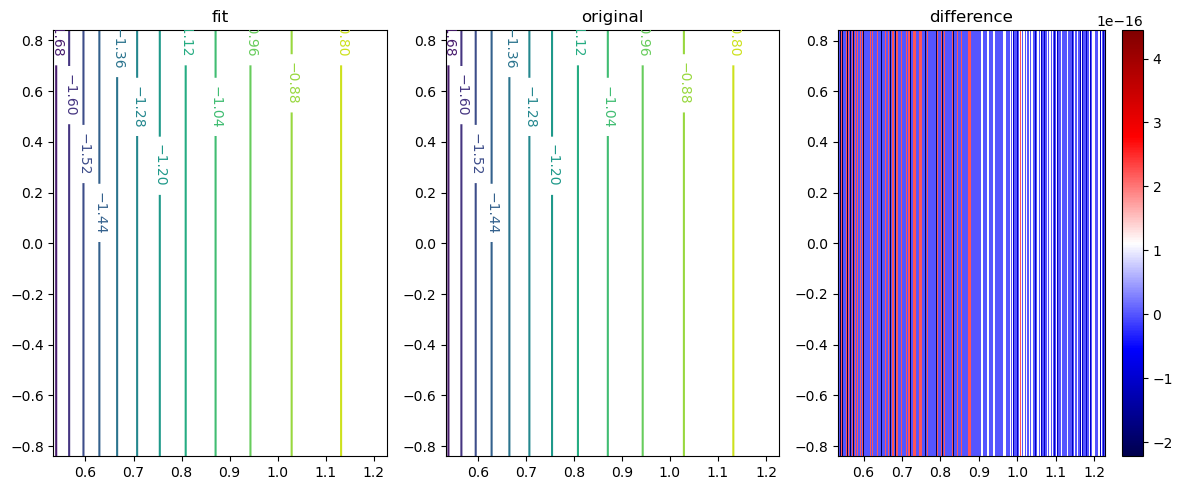

In [20]:
# Plot the numerical result
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 5), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R, Z, Bphi_ana, 11)
ax.clabel(cf)
ax.set_title("fit")
ax = axes[0][1]
cf = ax.contour(R, Z, Bphi, 11)
ax.set_title("original")
ax.clabel(cf)
ax = axes[0][2]
pc = ax.pcolormesh(R, Z, (Bphi_ana - Bphi), cmap = 'seismic')
ax.set_title("difference")
fig.colorbar(pc, ax=ax)
fig.tight_layout()

plt.show()

We see that the toroidal magnetic field fits very well

### The poloidal field
FELTOR's polynomial 
fit is given by
\begin{align}
 \frac{\psi}{B_0R_0 \rho_s} = P_\psi \frac{R_0}{\rho_s}\sum_{ij=1}^{N_R,N_Z} c_{ij}\left(\frac{R}{R_0}\right)^i \left(\frac{Z}{R_0}\right)^j
 \end{align}
 The $P_\psi$ coefficient can be used to later change the direction
of the poloidal field. In the setup here, we choose $P_\psi=1$.


In [21]:
PP = 1

In [22]:
# In order to accelerate the fit it is sometimes a good idea
# to not take all points. It is sufficient to only take every 10th point say
# Also , if the data includes coils and other stuff inside the wall it is a good idea to adapt minx, maxx, etc.
miny = 0
maxy = -1 
minx = 0
maxx = -1
Psimax = -0.05 # ( adapt for plot )
every = 5
Rred = R[miny:maxy:every, minx:maxx:every]
Zred = Z[miny:maxy:every, minx:maxx:every]
Psired = Psi[miny:maxy:every, minx:maxx:every]

Bphired = Bphi[miny:maxy:every, minx:maxx:every]

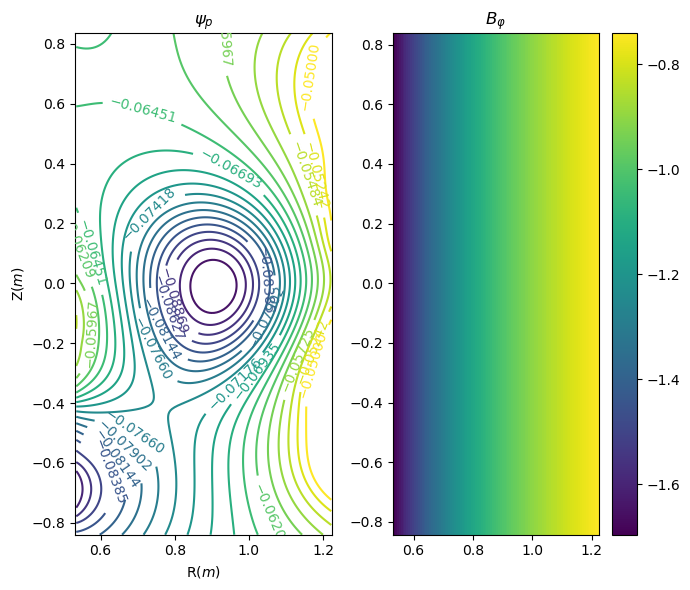

In [23]:
# For easier choice of minx, maxx etc. we have plot the flux function

fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True,
                         figsize=(7,6), squeeze=False)

ax = axes[0][0]
levels = np.linspace( Psi[o_point][0], Psimax, 20)
cf = ax.contour(Rred,Zred,Psired,levels=levels)
ax.clabel(cf)
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$\psi_p$')
ax = axes[0][1]
cf = ax.pcolormesh(Rred,Zred,Bphired)
fig.colorbar(cf,ax=ax)
ax.set_title(r'$B_\varphi$')
fig.tight_layout()

plt.show()

In [24]:
# The degree of the polynomial determines how long the fitting
# takes but also how good the fit will be
degR = 8
degZ = 16
params = dg.geo.polynomial.Parameters()
params.R_0 = R0
params.pp = PP
params.M = degR  # degree in R
params.N = degZ  # degree in Z

c = np.array(np.zeros(degR * degZ))

def psi_fit(x, *c):
    """ The function to fit to the data """
    R, Z = x

    params.c = list(c)

    psip = dg.geo.polynomial.Psip(params)
    return psip(R, Z)

In [25]:
# With this function we can experiment to weigh the fitting 
# It usually works better without

def sigma ( psi): 
    # if psi > Psimax:
    #     return 10000 #basically removes these points from fit
    # else:
        return 1

In [26]:
# We need to ravel the meshgrids of X, Y points
# to a pair of 1-D arrays:
coords = np.vstack((Rred.ravel(), Zred.ravel()))
psip_exp = Psired.ravel()
# in case we have a sigma
weights = np.array([sigma(psi) for psi in psip_exp])

In [27]:
import time

start = time.monotonic()
# Here comes the fit (might take a while)
copt, pcov = curve_fit(psi_fit, coords, psip_exp, c, weights)
stop = time.monotonic()
print("Took / s", stop - start)
print(copt)

Took / s 23.218769117997
[-1.96562399e+00 -3.52929160e+00  2.02825802e+01  1.41844936e+01
 -3.55341258e+01 -1.65266884e+00 -1.05774407e+02 -8.20794879e+01
  5.96702903e+02  2.33108372e+02 -1.14892055e+03 -3.33581090e+02
  9.24575365e+02  2.53897776e+02 -2.25830715e+02 -8.42294139e+01
  1.95421802e+01  2.28396525e+01 -1.86383715e+02 -8.94773590e+01
  3.77737615e+02  6.63251235e+01  1.47308791e+02  1.30448989e+02
 -2.04084459e+03 -4.19427424e+02  4.35539860e+03  7.06763470e+02
 -3.53924054e+03 -6.98335119e+02  6.94688582e+02  3.07599396e+02
 -8.09410372e+01 -6.27501446e+01  7.09475970e+02  2.28680932e+02
 -1.46638111e+03 -1.87670313e+02  7.00959164e+02  3.64136340e+01
  1.78157844e+03 -1.55316253e+02 -5.46316574e+03 -2.43198523e+01
  4.88234012e+03  5.28222324e+02 -5.48925347e+02 -4.36353241e+02
  1.78087199e+02  9.29649978e+01 -1.45203831e+03 -2.99797967e+02
  2.80825128e+03  1.49019992e+02 -1.67029230e+03  1.81182088e+01
  3.64003894e+02  4.81399061e+02  2.21808097e+03 -6.19561962e+02


Let's see how good the fit is

In [28]:
coords = np.vstack((R.ravel(), Z.ravel()))
psip_fit = psi_fit(coords, *copt)
psip_fit = psip_fit.reshape(R.shape)
difference = psip_fit - Psi
print(
    "Relative Error in Psi is      ",
    np.linalg.norm(difference, ord=2) / np.linalg.norm(Psi.ravel(), ord=2),
)

Relative Error in Psi is       0.0013686774490451244


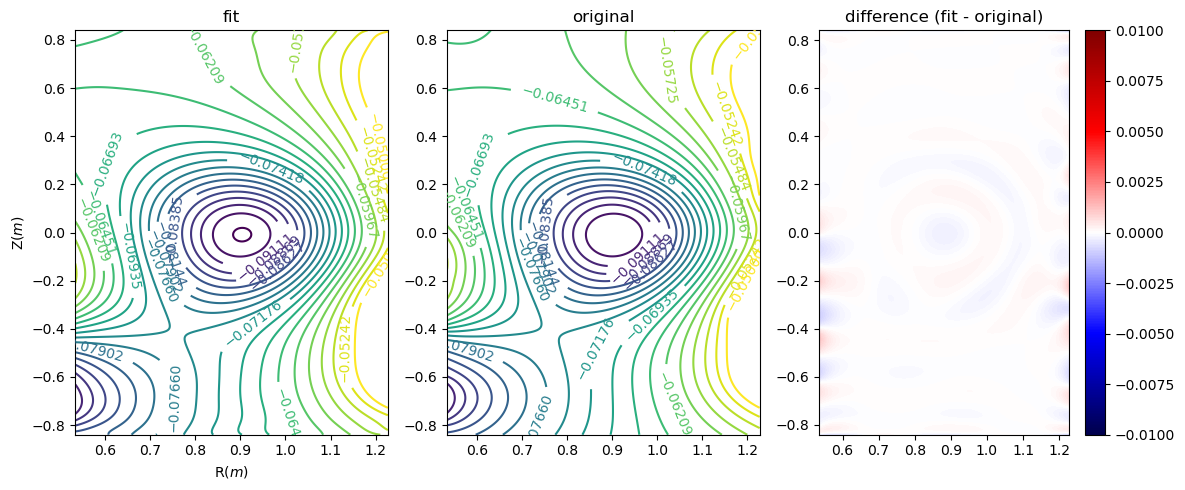

In [29]:
# Plot the numerical result, the original Psi and the difference
# In NORMALIZED UNITS
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 5), squeeze=False)

ax = axes[0][0]
levels = np.linspace( Psi[o_point][0], Psimax, 20)
cf = ax.contour(R, Z, psip_fit, levels)
ax.clabel(cf)
ax.set_title("fit")
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax = axes[0][1]
cf = ax.contour(R, Z, Psi, levels)
ax.clabel(cf)
ax.set_title("original")
ax = axes[0][2]
cf = ax.pcolormesh(R, Z, (psip_fit - Psi), cmap = 'seismic', vmin = -1e-2, vmax = 1e-2)
ax.set_title("difference (fit - original)")
fig.colorbar(cf, ax=ax)
fig.tight_layout()

plt.show()

## 4 Final Steps

FELTOR wants the last closed flux surface to be the $\psi_p=0$ line. 
To this end we need
to find the X-point (attention: innermost X-point when there are several X-points) and subtract the $\psi_X$ value
from the $c_{00}$ coefficient.

Now, FELTOR finds the first X-point by starting a Newton search near
\begin{align}
R_X =& R_0 - 1.1 \delta a \\
Z_X =& -1.1 \epsilon a
\end{align}
where $\delta $ is the triangularity and $\epsilon$ the elongation. The second X-point is searched near
\begin{align}
R_X =& R_0 - 1.1 \delta a \\
Z_X =& +1.1 \epsilon a
\end{align}

In [30]:
# Choose minor radius, elongation and triangularity such that all X-points are found in the next cell

a = 0.25 # estimated from the above figure
elongation = 1.5  # an estimation
triangularity = 0.4  # an estimation
# Just a human readable comment in the geometry input file
comment = "least squares fit; Matlab geometry file of TCV equilibrium for Enabling research project: X-point"
# The description is important and serves as a hint of what FELTOR expects.
# For example an X-point is only searched for "standardX", "doubleX" or "centeredX" descriptions
description = "standardX" # standardO, standardX, doubleX, none, square or centeredX

geom_file = {
    "M": degR,
    "N": degZ,
    "c": copt.tolist(),
    "PP": PP,
    "PI": PI,
    "R_0": R0,  # R0 in rho_s; this is the value you have to change later once you determined rho_s
    "elongation": elongation,
    "triangularity": triangularity,
    "inverseaspectratio": a / R0,
    "equilibrium": "polynomial",  # the fit function we used
    "description": description,  # we only have one X-point
    "comment": comment,
}

In [31]:
mag = dg.geo.createMagneticField( geom_file)
psip = mag.get_psip()

# Consistency Check
RO = R0
ZO = 0
point,RO,ZO = dg.geo.findOpoint( psip, RO,ZO)
psipO = mag.psip()(RO,ZO)
print( "O-point found at", RO, ZO, "of type", point , "(1 min, 2 max) with value ", psipO)

RX = R0 - 1.1*mag.params().triangularity()*a
ZX = -1.1*mag.params().elongation()*a
# print(RX,ZX)
RX, ZX = dg.geo.findXpoint( psip, RX, ZX)
psipX = mag.psip()(RX,ZX)
print( "X-point at ", RX, ZX, " with value ", psipX)

# RX2 = R0 - 1.1*mag.params().triangularity()*a
# ZX2 = +1.1*mag.params().elongation()*a
# RX2, ZX2 = dg.geo.findXpoint( psip, RX2, ZX2)
# print( "2nd X-point at ", RX2, ZX2, " with value ", mag.psip()(RX2,ZX2))
# if abs(psipX2-psipO) < abs(psipX-psipO) : 
#     psipX = psipX2
#     print( "2nd X-point is closer to O-point!")

# Update the zero coefficient
geom_file["c"][0] = copt[0] - psipX / PP / R0

O-point found at 0.9041570646350381 -0.008729243602984924 of type 1 (1 min, 2 max) with value  -0.0962222403545417
X-point at  0.7592147889658485 -0.41582409459302894  with value  -0.07429092133137752


### Create File
We are now ready to write the coefficients to a file.
Read the documentation of
[`dg::geo::createMagneticField`](https://mwiesenberger.github.io/feltor/geometries/html/group__geom.html#gaa0da1d1c2db65f1f4b28d77307ad238b) to find out about valid fields in your `json` file

In [32]:
outfile = "enrx_tcv.json"
with open(outfile, "w") as f:
    print(json.dumps(geom_file, indent=4), file=f)

### Final consistency checks
Now, as a final check we can plot the magnetic field from the file we just created

In [33]:
mag = dg.geo.createMagneticField(geom_file)
cPsi = mag.psip()(Rred, Zred)
cBR = dg.geo.BFieldR(mag)(Rred, Zred)
cBZ = dg.geo.BFieldZ(mag)(Rred, Zred)
cBphi = dg.geo.BFieldP(mag)(Rred, Zred) * Rred  # BFieldP is the contravariant component

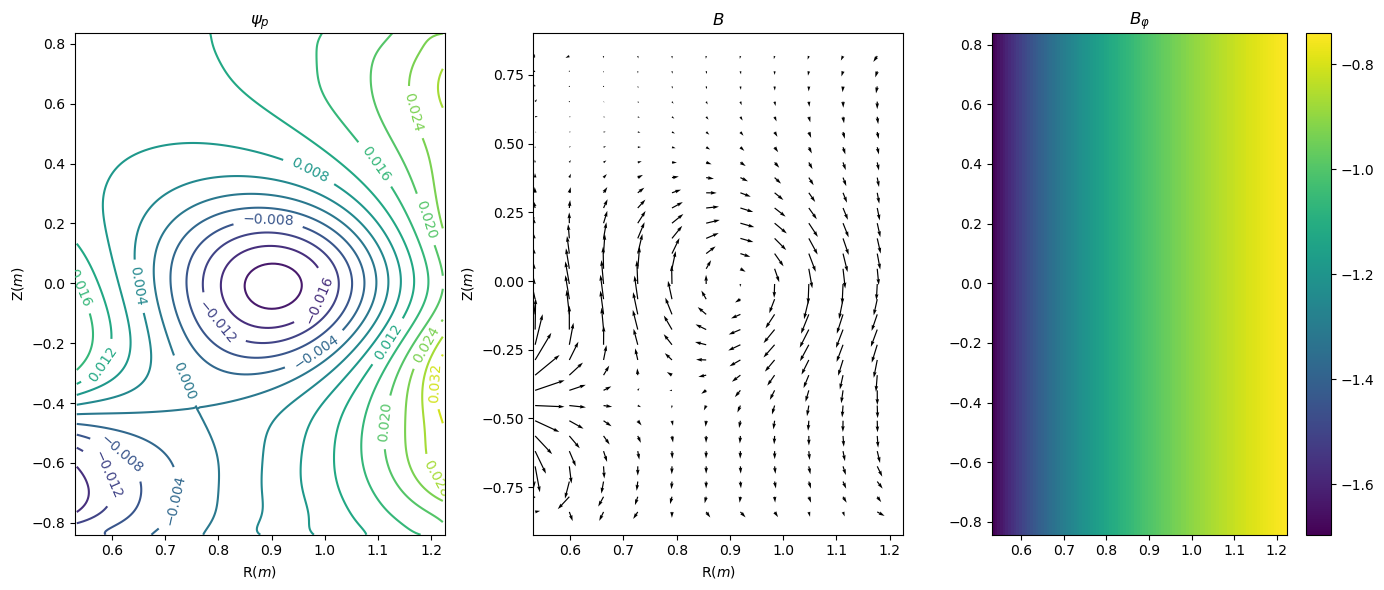

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(14, 6), squeeze=False)

ax = axes[0][0]
cf = ax.contour(Rred, Zred, cPsi, 15)
ax.clabel(cf)
ax.set_xlabel(r"R($m$)")
ax.set_ylabel(r"Z($m$)")
ax.set_title(r"$\psi_p$")
ax = axes[0][1]
q = ax.quiver(
    Rred[::10, ::10], Zred[::10, ::10], cBR[::10, ::10], cBZ[::10, ::10],
    units="width"
)
ax.set_xlabel(r"R($m$)")
ax.set_ylabel(r"Z($m$)")
ax.set_title(r"$B$")
ax = axes[0][2]
cf = ax.pcolormesh(Rred, Zred, cBphi)
fig.colorbar(cf, ax=ax)
ax.set_title(r"$B_\varphi$")
fig.tight_layout()

plt.show()

### q-profile

In the FELTOR coordinate conventions **q is positive for right-handed field winding** and negative for left-handed winding.

Note that we have 
\begin{align}
\psi_t = \int^{\psi_p} q(\psi_p)  d\psi_p
\end{align}

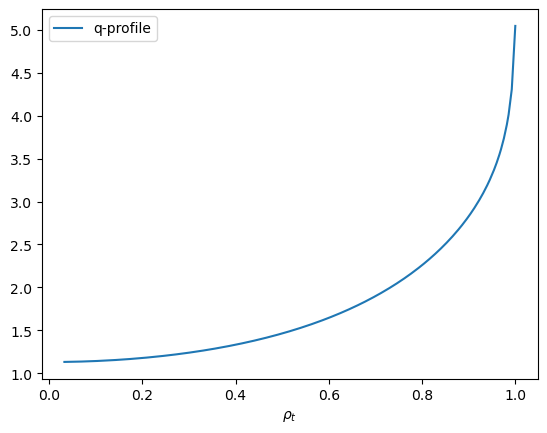

The q 95 value is 3.312


In [35]:
qfunctor = dg.geo.SafetyFactor(mag)
# avoid being too close to the O-point and the separatrix
# Our psip values go from psipO to 0
psipO = mag.psip()(RO, ZO)
psi_grid = dg.Grid(psipO, 0, 3, 64)
psi_values = dg.evaluate(lambda x: x, psi_grid)

rhop = np.sqrt((psipO - psi_values) / psipO)
qprof = dg.evaluate(qfunctor, psi_grid)
psit = dg.integrate(qprof, psi_grid)

# plt.plot(rhop , psit)
rhot = np.sqrt(psit / psit[-1])
plt.plot(rhot, qprof, label="q-profile")
plt.xlabel(r"$\rho_t$")
plt.legend()
plt.show()
q95 = np.interp(0.95, rhot, qprof)
print("The q 95 value is", np.round(q95, decimals=3))

In [36]:
# # Eqdsk files have a q-profile that can be used to compare
# qprof_exp = data["qpsi"]
# psi_values_exp = np.linspace(data["simagx"], data["sibdry"], data["nx"])
# psit_exp = [np.trapz( qprof_exp[0:i+1], psi_values_exp[0:i+1])
#             for i in range( 0,np.size(psi_values_exp))]
# rhot_exp = np.sqrt( psit_exp/psit_exp[-1])
# plt.plot( rhot_exp , qprof_exp, label = 'eqdsk')
# plt.legend()
# plt.plot(rhot, -qprof, label="FELTOR")
# plt.xlabel(r"$\rho_t$")
# plt.ylabel(r"$q$")
# plt.legend()
# plt.show()
# q95_exp = np.interp(0.95, rhot_exp, qprof_exp)
# print("The eqdsk q 95 value is", np.round(q95_exp, decimals=3))

If everything went well the geometry file is now ready to use; WELL DONE!! 